# Whatami

I am a simple experiment on using qlearning agent setup for MountainCar problem.
Being off-policy value based algorithm, qlearning has comparatively poor convergence on this problem (see a2c nearby for comparison) yet it does manage to find some policy that brings him to the end.


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
!pip install --upgrade https://github.com/yandexdataschool/agentnet/archive/master.zip

     \ 4.6MB 62.7MB/s
Requirement already up-to-date: six in /Users/alexajax/anaconda3/lib/python3.5/site-packages (from agentnet==0.10.1)
Requirement already up-to-date: lasagne in /Users/alexajax/anaconda3/lib/python3.5/site-packages (from agentnet==0.10.1)
Requirement already up-to-date: theano>=0.8.2 in /Users/alexajax/anaconda3/lib/python3.5/site-packages (from agentnet==0.10.1)
    100% |################################| 4.2MB 105kB/s 
    100% |################################| 21.0MB 20kB/s 
  Found existing installation: numpy 1.11.1
    Uninstalling numpy-1.11.1:
      Successfully uninstalled numpy-1.11.1
  Running setup.py install for agentnet ... - \ | / done
  Found existing installation: scipy 0.18.0
    Uninstalling scipy-0.18.0:
      Successfully uninstalled scipy-0.18.0


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"

env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "MountainCar-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [4]:
import gym
env = gym.make(GAME)
env.reset()
obs = env.step(0)[0]
action_names = np.array(["left",'stop',"right"]) #i guess so... i may be wrong
state_size = len(obs)
print(obs)

[2017-01-06 12:30:24,158] Making new env: MountainCar-v0


[-0.50631884 -0.00113806]


In [ ]:
#plt.imshow(env.render('rgb_array'))

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [5]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer


inp = InputLayer((None,len(env.reset())),)
h1 = DenseLayer(inp,100,nonlinearity= lasagne.nonlinearities.sigmoid,name="h1")
h2 = DenseLayer(h1,100, nonlinearity= lasagne.nonlinearities.sigmoid,name="h2")



In [6]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(h2,env.action_space.n,nonlinearity=lambda x:x,name='q')

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

action_layer.epsilon.set_value(np.float32(0.05))


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [7]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=inp,
              policy_estimators=qvalues_layer,
              action_layers=action_layer)


In [8]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[h1.W, h1.b, h2.W, h2.b, q.W, q.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [47]:
action_layer.epsilon.set_value(1)

In [9]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2017-01-06 12:32:21,683] Making new env: MountainCar-v0


In [10]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['right' 'right' 'right' 'right' 'right' 'right' 'left']]
[[-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 8.63 ms, sys: 4.37 ms, total: 13 ms
Wall time: 10.4 ms


In [11]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH,append=True)

/Users/alexajax/anaconda3/lib/python3.5/site-packages/agentnet/environment/session_pool.py:292: UserWarning: Warning! Appending sessions to empty or broken pool. Old pool sessions, if any, are disposed.
  warn("Warning! Appending sessions to empty or broken pool. Old pool sessions, if any, are disposed.")


In [73]:
#pool.experience_replay.observations[0].get_value()

In [62]:
pool.experience_replay.actions[0].get_value()

array([[1, 0, 1, 1, 0, 1, 1, 1, 0, 1]], dtype=int32)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [12]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



/Users/alexajax/anaconda3/lib/python3.5/site-packages/agentnet/agent/mdp_agent.py:142: UserWarning: optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.
  warn("optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.")


In [94]:
qvalues_seq[:,1:].max(axis=-1).eval()

array([[-0.02037258, -0.0174741 , -0.01458271, -0.01171049, -0.01362546,
        -0.01068456, -0.02714266, -0.02435617, -0.02155882],
       [-0.01875621, -0.01595514, -0.01316381, -0.01525919, -0.01739132,
        -0.01443514, -0.01150815, -0.01333672, -0.0103538 ],
       [-0.0277649 , -0.03054962, -0.02786106, -0.02515127, -0.02242419,
        -0.01968434, -0.01693809, -0.01419264, -0.01145744],
       [-0.01347649, -0.01064287, -0.01249374, -0.00958401, -0.00672869,
        -0.02639769, -0.02374883, -0.02654316, -0.02387926]], dtype=float32)

In [14]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [15]:
# Compute weight updates
updates = lasagne.updates.sgd(loss,weights,learning_rate=0.01)

In [16]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [17]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records/geonerus",record_video=True)

[2017-01-06 12:40:03,567] Making new env: MountainCar-v0
[2017-01-06 12:40:03,585] Attempted to wrap env <MountainCarEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-01-06 12:40:03,588] Creating monitor directory ./records/geonerus
[2017-01-06 12:40:03,592] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/geonerus/openaigym.video.0.84870.video000000.mp4
[2017-01-06 12:40:10,310] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alexajax/Downloads/goto/records/geonerus')


Episode finished after 200 timesteps with reward=-200.0


In [105]:
from IPython.display import HTML

video_path="records/openaigym.video.0.54912.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [106]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [109]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,)


100%|██████████| 1000/1000 [00:06<00:00, 143.94it/s]


In [110]:
pool.experience_replay.observations[0].eval().shape

(1004, 10, 4)

In [119]:

#the loop may take eons to finish.
#consider interrupting early.
for i in tqdm(range(10000)):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True,)
    for i in range(5):
        loss = train_step()
        
    
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        action_layer.epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=True,n_games=n_games,verbose=True)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        action_layer.epsilon.set_value(0.05)
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  5%|▍         | 498/10000 [00:24<08:13, 19.26it/s][2017-01-06 12:18:48,838] Making new env: CartPole-v0
[2017-01-06 12:18:48,852] Attempted to wrap env <CartPoleEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-01-06 12:18:48,854] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-01-06 12:18:48,856] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.2.54912.video000000.mp4
[2017-01-06 12:18:49,283] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.2.54912.video000001.mp4


Episode finished after 9 timesteps with reward=9.0


[2017-01-06 12:18:49,615] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.2.54912.video000008.mp4


Episode finished after 8 timesteps with reward=8.0
Episode finished after 9 timesteps with reward=9.0
Episode finished after 9 timesteps with reward=9.0
Episode finished after 8 timesteps with reward=8.0
Episode finished after 10 timesteps with reward=10.0
Episode finished after 9 timesteps with reward=9.0
Episode finished after 10 timesteps with reward=10.0


[2017-01-06 12:18:49,972] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alexajax/Downloads/goto/records')
  5%|▌         | 502/10000 [00:25<27:10,  5.83it/s]

Episode finished after 10 timesteps with reward=10.0
Episode finished after 9 timesteps with reward=9.0
Current score(mean over 10) = 9.100


 10%|▉         | 998/10000 [00:53<08:30, 17.63it/s][2017-01-06 12:19:17,881] Making new env: CartPole-v0
[2017-01-06 12:19:17,897] Attempted to wrap env <CartPoleEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-01-06 12:19:17,900] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-01-06 12:19:17,903] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.3.54912.video000000.mp4
[2017-01-06 12:19:22,737] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.3.54912.video000001.mp4


Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0


[2017-01-06 12:19:30,570] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.3.54912.video000008.mp4


Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0


 10%|▉         | 998/10000 [01:10<10:31, 14.25it/s]

Episode finished after 200 timesteps with reward=200.0


[2017-01-06 12:19:35,528] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alexajax/Downloads/goto/records')
 10%|█         | 1002/10000 [01:10<4:46:44,  1.91s/it]

Episode finished after 200 timesteps with reward=200.0
Current score(mean over 10) = 200.000


 15%|█▍        | 1499/10000 [01:38<07:07, 19.88it/s][2017-01-06 12:20:02,811] Making new env: CartPole-v0
[2017-01-06 12:20:02,829] Attempted to wrap env <CartPoleEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-01-06 12:20:02,830] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-01-06 12:20:02,834] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.4.54912.video000000.mp4
[2017-01-06 12:20:07,358] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.4.54912.video000001.mp4


Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 174 timesteps with reward=174.0
Episode finished after 200 timesteps with reward=200.0


[2017-01-06 12:20:12,005] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.4.54912.video000008.mp4


Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0


 15%|█▌        | 1500/10000 [01:51<9:27:22,  4.01s/it]

Episode finished after 197 timesteps with reward=197.0
Episode finished after 200 timesteps with reward=200.0
Current score(mean over 10) = 197.100


 20%|█▉        | 1999/10000 [02:18<07:24, 18.00it/s][2017-01-06 12:20:43,287] Making new env: CartPole-v0
[2017-01-06 12:20:43,302] Attempted to wrap env <CartPoleEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-01-06 12:20:43,304] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-01-06 12:20:43,307] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.5.54912.video000000.mp4
[2017-01-06 12:20:46,802] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.5.54912.video000001.mp4


Episode finished after 120 timesteps with reward=120.0
Episode finished after 140 timesteps with reward=140.0
Episode finished after 124 timesteps with reward=124.0
Episode finished after 112 timesteps with reward=112.0
Episode finished after 139 timesteps with reward=139.0
Episode finished after 123 timesteps with reward=123.0


[2017-01-06 12:20:50,184] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.5.54912.video000008.mp4


Episode finished after 120 timesteps with reward=120.0
Episode finished after 132 timesteps with reward=132.0


[2017-01-06 12:20:53,046] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alexajax/Downloads/goto/records')
 20%|██        | 2001/10000 [02:28<3:22:30,  1.52s/it]

Episode finished after 123 timesteps with reward=123.0
Episode finished after 118 timesteps with reward=118.0
Current score(mean over 10) = 125.100


 25%|██▍       | 2499/10000 [02:55<06:44, 18.57it/s][2017-01-06 12:21:20,221] Making new env: CartPole-v0
[2017-01-06 12:21:20,239] Attempted to wrap env <CartPoleEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-01-06 12:21:20,242] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-01-06 12:21:20,245] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.6.54912.video000000.mp4
[2017-01-06 12:21:23,172] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.6.54912.video000001.mp4


Episode finished after 99 timesteps with reward=99.0
Episode finished after 105 timesteps with reward=105.0
Episode finished after 98 timesteps with reward=98.0
Episode finished after 109 timesteps with reward=109.0
Episode finished after 113 timesteps with reward=113.0
Episode finished after 105 timesteps with reward=105.0
Episode finished after 93 timesteps with reward=93.0


[2017-01-06 12:21:26,171] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.6.54912.video000008.mp4


Episode finished after 99 timesteps with reward=99.0


[2017-01-06 12:21:28,643] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alexajax/Downloads/goto/records')


Episode finished after 98 timesteps with reward=98.0
Episode finished after 101 timesteps with reward=101.0
Current score(mean over 10) = 102.000


 30%|██▉       | 2999/10000 [03:32<06:16, 18.61it/s][2017-01-06 12:21:57,308] Making new env: CartPole-v0
[2017-01-06 12:21:57,326] Attempted to wrap env <CartPoleEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-01-06 12:21:57,328] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-01-06 12:21:57,331] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.7.54912.video000000.mp4
[2017-01-06 12:22:00,333] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.7.54912.video000001.mp4


Episode finished after 101 timesteps with reward=101.0
Episode finished after 92 timesteps with reward=92.0
Episode finished after 90 timesteps with reward=90.0
Episode finished after 96 timesteps with reward=96.0
Episode finished after 102 timesteps with reward=102.0
Episode finished after 98 timesteps with reward=98.0
Episode finished after 97 timesteps with reward=97.0


[2017-01-06 12:22:02,888] Starting new video recorder writing to /Users/alexajax/Downloads/goto/records/openaigym.video.7.54912.video000008.mp4


Episode finished after 91 timesteps with reward=91.0


[2017-01-06 12:22:05,545] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alexajax/Downloads/goto/records')


Episode finished after 91 timesteps with reward=91.0
Episode finished after 94 timesteps with reward=94.0
Current score(mean over 10) = 95.200


 30%|███       | 3023/10000 [03:42<09:54, 11.73it/s]

KeyboardInterrupt: 

In [26]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))

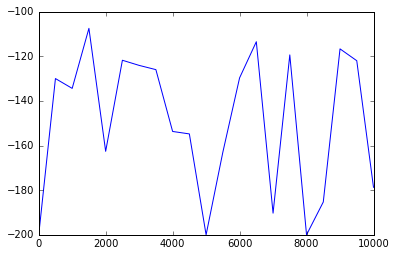

In [27]:
plt.plot(iters,map(np.mean,session_rewards))